In [1]:
import io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)

In [2]:
# Summary: you can call line.split() to immediately get the tokenized version of 
# the sentences. Normally you would have to run the text through a proper tokenizer.
"""
You should create a subclass for Dataset, but not for Dataloader. 
You should probably also define a custom collate_fn, 
but you should also only need to do this once.
You will instantiate separate Datasets: e.g. train_dataset and val_dataset. 
Then you should create a Dataloader around each one: train_dataloader and val_dataloader.
For your max length, that should be determined based on your training set 
(you should pretend you do not have access to your validation set when choosing 
such "hyperparameters", to avoid biasing your results.

sent1_vector = rnn(sent1)
sent2_vector = rnn(sent2)
combined_vector = torch.cat([sent1_vector, sent2_vector], dim=1)

nn.Sequential(nn.Linear(x, hidden_size), 
              nn.ReLU(inplace=True), 
              nn.Linear(hidden_size, num_classes))

You are required to concatenate the representations, not the sentences. 
The idea is that you will encode each of your sentences through an 
encoder (CNN or RNN) and extract a fixed-length vector representation 
of the sentences. You will then concatenate the two representations and 
feed that through a fully-connected layer.

Transfer the string into word vectors using fast text, process 
them with data loader, feed them separately into the encoder, 
get the output representation, concat them and then fed that into a 
fully-connected layer for classification.
"""
""

''

In [3]:
# Run this so your plots show properly
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]
def get_plot_values(accuracies):
    training_acc = [acc[2] for acc in accuracies]
    val_acc = [acc[3] for acc in accuracies]
    training_acc_fmt = []
    for i, acc in enumerate(training_acc):
        if i % 6 == 0:
            continue
        elif i % 7 == 0:
            continue
        else:
            training_acc_fmt.append(acc)
    val_acc_fmt = []
    for i, acc in enumerate(val_acc):
        if i % 6 == 0:
            continue
        elif i % 7 == 0:
            continue
        else:
            val_acc_fmt.append(acc)
    return training_acc_fmt, val_acc_fmt

In [25]:
accuracies_gru_loaded = pkl.load(open("gru_accuracies", "rb"))
gru_training, gru_val = get_plot_values(accuracies_gru_loaded)
accuracies_cnn_loaded = pkl.load(open("cnn_accuracies2", "rb"))
cnn_training, cnn_val = get_plot_values(accuracies_cnn_loaded)


plt.plot(list(np.arange(0, 20, 0.2)), gru_training, label="GRU Training Accuracy", color='purple', linestyle='--') 
plt.plot(list(np.arange(0, 20, 0.2)), gru_val, label="GRU Validation Accuracy", color='purple') 
plt.plot(list(np.arange(0, 20, 0.2)), cnn_training, label="CNN Training Accuracy", color='blue', linestyle='--') 
plt.plot(list(np.arange(0, 20, 0.2)), cnn_val, label="CNN Validation Accuracy", color='blue') 


plt.title('Comparing Accuracy For Base GRU and CNN models')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([0, 20])
plt.xticks(list(range(0,21,2)))
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.0003 and hidden=200"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'gru_accuracies'

In [ ]:
accuracies_gru_loaded = pkl.load(open("gru_accuracies_0.003_2", "rb"))
gru_training, gru_val = get_plot_values(accuracies_gru_loaded)


plt.plot(list(np.arange(0, 10, 0.2)), gru_training, label="GRU Training Accuracy", color='purple', linestyle='--') 
plt.plot(list(np.arange(0, 10, 0.2)), gru_val, label="GRU Validation Accuracy", color='purple') 
# plt.plot(list(np.arange(0, 20, 0.2)), cnn_training, label="CNN Training Accuracy", color='blue', linestyle='--') 
# plt.plot(list(np.arange(0, 20, 0.2)), cnn_val, label="CNN Validation Accuracy", color='blue') 


plt.title('Trying Faster Learning Rate for GRU')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([0, 7])
plt.xticks(list(range(0,8,1)))
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.003 and hidden=200"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

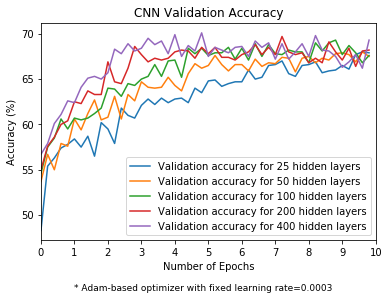

In [24]:
gru_learning_rate = 3e-4
hidden_layers = [25, 50, 100, 200, 400]
for layer in hidden_layers:
    accuracies_gru_loaded = pkl.load(open("cnn_accuracies2_{}_{}".format(gru_learning_rate,layer), "rb"))
    gru_training, gru_val = get_plot_values(accuracies_gru_loaded)
    plt.plot(list(np.arange(0, 10, 0.2)), gru_val, label="Validation accuracy for {} hidden layers".format(layer)) 


plt.title('CNN Validation Accuracy')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([0, 10])
plt.xticks(list(range(0,11,1)))
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.0003"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

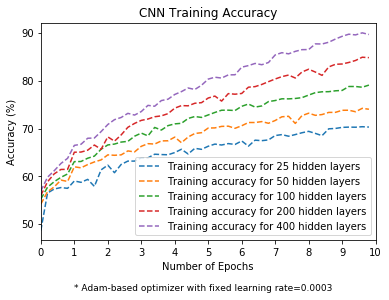

In [23]:
gru_learning_rate = 3e-4
hidden_layers = [25, 50, 100, 200,400]
for layer in hidden_layers:
    accuracies_gru_loaded = pkl.load(open("cnn_accuracies2_{}_{}".format(gru_learning_rate,layer), "rb"))
    gru_training, gru_val = get_plot_values(accuracies_gru_loaded)
    plt.plot(list(np.arange(0, 10, 0.2)), gru_training, label="Training accuracy for {} hidden layers".format(layer), linestyle='--') 


plt.title('CNN Training Accuracy')
plt.legend(loc = 'lower right')
# plt.ylim([0, 15])
plt.xlim([0, 10])
plt.xticks(list(range(0,11,1)))
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Epochs')
txt="* Adam-based optimizer with fixed learning rate=0.0003"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

In [ ]:
def 

mdb = ModelDatasetBuilder('hw2_data', vocab_size=50000)
mdb.load_fasttext_vectors_into_vocabulary('wiki-news-300d-1M.vec')
embeddings = mdb.get_embedding_vector()
print(embeddings)
training_vectors, val_vectors = mdb.get_indexed_text_vectors()
print(training_vectors)